## Inference
Test if we can run the saved models

In [9]:
import sys
import xarray as xr
import torch
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sys.path.append('../src')
from Inference import sample_unet, sample_model_EDS
from Network import UNet, EDMPrecond
from DatasetUS import UpscaleDataset

from torch.utils.data.dataloader import DataLoader

Set up models

In [10]:
# Subset of years
year_start = 1953
year_end = 1954

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Dirs
data_dir="../data/"
model_dir="../"


cuda


Get checkpoints of models for both UNet and Diffusion

In [11]:
# Get models - using architecture that matches the saved checkpoints
# unet - 5 input channels, 3 output channels (matches saved checkpoint)
model_unet = UNet((256, 128), 5, 3, label_dim=2, use_diffuse=False).to(device)
model_unet.load_state_dict(torch.load(f"{model_dir}/Model_chpt/unet.pt"))
# diffusion - 8 input channels, 3 output channels (matches saved checkpoint)
model_diff = EDMPrecond((256, 128), 8, 3).to(device)
model_diff.load_state_dict(torch.load(f"{model_dir}/Model_chpt/diffusion.pt"))

C:\Users\khosl\AppData\Local\Temp\ipykernel_43392\2848462156.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_unet.load_state_dict(torch.load(f"{model_dir}/Model_ch

<All keys matched successfully>

Open datasets

In [12]:
# define the datasets
datadir = "../data/"

dataset_test = UpscaleDataset(datadir, year_start=year_start, year_end=year_end,
                              constant_variables=["lsm", "z"])

lat = dataset_test.lat
lon = dataset_test.lon

nlat, nlon = len(lat), len(lon)

BATCH_SIZE = 1
dataloader = DataLoader(dataset_test,
                        batch_size=BATCH_SIZE,
                        shuffle=False)


Opening files
All files accessed. Creating tensors
Original data shape: torch.Size([360, 128, 256])
Original time steps: 360
Using full time steps: 360 (no reduction)
torch.Size([1])
tensor([259.5524]) tensor([310.5276])
Opening constant variables file (e.g. land-sea mask, topography)
Normalize z
Mean:4599.646526826994, Std6220.799692544967
Dataset initialized.


 Sample our batch of 1 for both models

In [13]:
t = 0   # time index
test_batch = next(iter(dataloader))

# Run models
coarse, fine, predicted_unet = sample_unet(test_batch, model_unet, 
                                           device, dataset_test)
_, _, predicted_diff = sample_model_EDS(test_batch, model_diff, 
                                        device, dataset_test, num_steps=40)

coarse = coarse.detach().numpy()
fine = fine.detach().numpy()
predicted_unet = predicted_unet.detach().numpy()
predicted_diff = predicted_diff.detach().numpy()


In [14]:
print(coarse.shape, fine.shape, predicted_unet.shape, predicted_diff.shape)

(1, 1, 128, 256) (1, 1, 128, 256) (1, 3, 128, 256) (1, 3, 128, 256)


## Plot
Plot all three variables for this one timestep

In [15]:
# Variables - only temperature for this simplified version
varnames = ["VAR_2T"]
vmin = [250]
vmax = [300]
vmax_stds = [3]
cmaps = ["rainbow"]

plot_varnames = ["Temperature"]
plot_var_labels = ["K"]
plt.rcParams.update({'font.size': 18})

<Figure size 640x480 with 0 Axes>

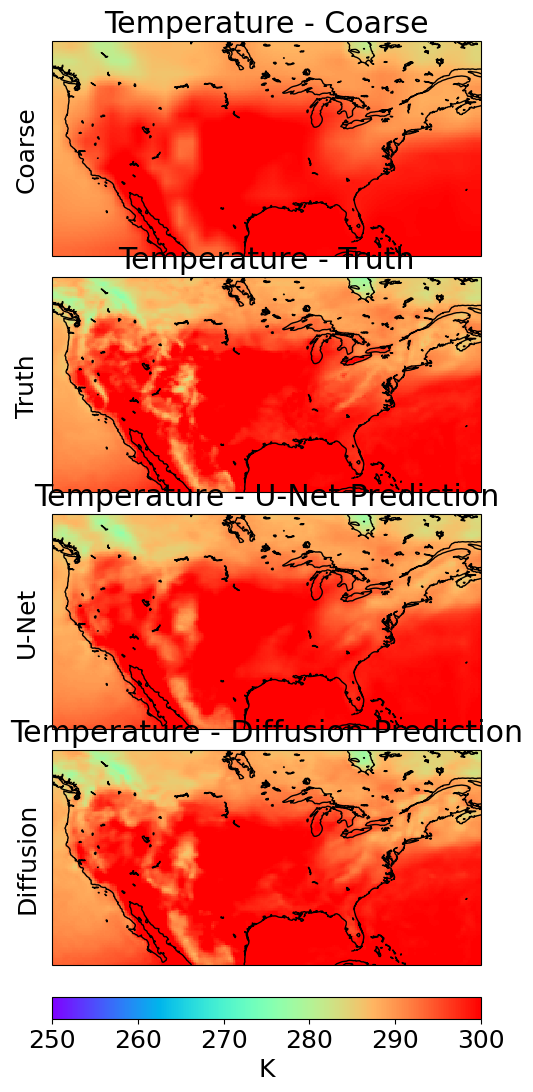

In [16]:
plt.clf()
fig, axs = plt.subplots(4,1, figsize=(8, 12),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        gridspec_kw={'wspace': 0.1,
                                     'hspace': 0.1})

# Plot temperature data (index 0 for temperature channel)
i = 0

# Plot coarse data
ax = axs[0]
plt.sca(ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')
pcm = plt.pcolormesh(lon, lat, coarse[0, i],
               vmin=vmin[i], vmax=vmax[i],
               shading='nearest',
               cmap=cmaps[i])
plt.title(f"{plot_varnames[i]} - Coarse")
plt.text(lon[0]-2, lat[len(lat) // 2], f"Coarse", transform=ccrs.PlateCarree(),
         rotation='vertical', ha='right', va='center', zorder=10)

# Plot truth data
ax = axs[1]
plt.sca(ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')
pcm = plt.pcolormesh(lon, lat, fine[0, i],
               vmin=vmin[i], vmax=vmax[i],
               shading='nearest',
               cmap=cmaps[i])
plt.title(f"{plot_varnames[i]} - Truth")
plt.text(lon[0]-2, lat[len(lat) // 2], f"Truth", transform=ccrs.PlateCarree(),
         rotation='vertical', ha='right', va='center', zorder=10)

# Plot U-Net prediction (use first channel for temperature)
ax = axs[2]
plt.sca(ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')
pcm = plt.pcolormesh(lon, lat, predicted_unet[0, 0],  # First channel (temperature)
               vmin=vmin[i], vmax=vmax[i],
               shading='nearest',
               cmap=cmaps[i])
plt.title(f"{plot_varnames[i]} - U-Net Prediction")
plt.text(lon[0]-2, lat[len(lat) // 2], f"U-Net", transform=ccrs.PlateCarree(),
         rotation='vertical', ha='right', va='center', zorder=10)

# Plot Diffusion prediction (use first channel for temperature)
ax = axs[3]
plt.sca(ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')
pcm = plt.pcolormesh(lon, lat, predicted_diff[0, 0],  # First channel (temperature)
               vmin=vmin[i], vmax=vmax[i],
               shading='nearest',
               cmap=cmaps[i])
plt.title(f"{plot_varnames[i]} - Diffusion Prediction")
plt.text(lon[0]-2, lat[len(lat) // 2], f"Diffusion", transform=ccrs.PlateCarree(),
         rotation='vertical', ha='right', va='center', zorder=10)
cax = ax.inset_axes([0., -0.25, 1, 0.1])
plt.colorbar(pcm, cax = cax, orientation="horizontal", label=f"{plot_var_labels[i]}")

plt.show()